In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from urllib.parse import urlparse

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [14]:
BATCH_SIZE = 8
NUM_EPOCHS = 40
LR = 5e-5

MAX_QUESTION_LEN = 40
EMBED_DIM = 300
HIDDEN_DIM = 256

TOP_K_ANSWERS = 50   # عدد الإجابات التي سيغطيها النموذج


In [15]:
BASE_DIR = "/content"

# Excel
excel_files = [f for f in os.listdir(BASE_DIR) if f.endswith(".xlsx")]
QA_FILE = os.path.join(BASE_DIR, excel_files[0])

# Images
image_dirs = [d for d in os.listdir(BASE_DIR)
              if os.path.isdir(os.path.join(BASE_DIR, d))
              and "image" in d.lower()]
IMAGE_ROOT = os.path.join(BASE_DIR, image_dirs[0])

df = pd.read_excel(QA_FILE)
df.columns = [c.lower().strip() for c in df.columns]

df = df.rename(columns={
    "imageid": "image_url",
    "question": "question",
    "answer": "answer"
})

df["answer"] = (
    df["answer"]
    .astype(str)
    .str.lower()
    .str.replace(".", "", regex=False)
    .str.strip()
)

# 🔹 اختيار أكثر الإجابات شيوعًا
top_answers = df["answer"].value_counts().nlargest(TOP_K_ANSWERS).index
df = df[df["answer"].isin(top_answers)]

answer2id = {a: i for i, a in enumerate(top_answers)}
id2answer = {i: a for a, i in answer2id.items()}

df["label"] = df["answer"].map(answer2id)

NUM_CLASSES = len(answer2id)
print("Number of classes:", NUM_CLASSES)

# 🔹 استخراج اسم الصورة من URL
def extract_filename(url):
    if not isinstance(url, str):
        return None
    return os.path.basename(urlparse(url).path)

df["image_name"] = df["image_url"].apply(extract_filename)

# 🔹 ربط الصور المحلية
all_images = {}
for root, _, files in os.walk(IMAGE_ROOT):
    for f in files:
        all_images[f] = os.path.join(root, f)

df["image_path"] = df["image_name"].map(all_images)
df = df[df["image_path"].notnull()].reset_index(drop=True)

print("Final dataset size:", len(df))


Number of classes: 50
Final dataset size: 1546


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [16]:
train_df, temp_df = train_test_split(
    df, test_size=0.3, random_state=42, shuffle=True
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, shuffle=True
)


In [17]:
from collections import Counter

def build_vocab(questions, min_freq=2):
    counter = Counter()
    for q in questions:
        counter.update(q.lower().split())
    vocab = {"<pad>": 0, "<unk>": 1}
    for w, f in counter.items():
        if f >= min_freq:
            vocab[w] = len(vocab)
    return vocab

VOCAB = build_vocab(train_df["question"])
VOCAB_SIZE = len(VOCAB)

def encode_question(q):
    tokens = q.lower().split()[:MAX_QUESTION_LEN]
    ids = [VOCAB.get(t, 1) for t in tokens]
    return ids + [0] * (MAX_QUESTION_LEN - len(ids))


In [19]:
train_tfms = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

eval_tfms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class VQADataset(Dataset):
    def __init__(self, df, tfm):
        self.df = df
        self.tfm = tfm

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        img = Image.open(r.image_path).convert("RGB")
        img = self.tfm(img)
        q = torch.tensor(encode_question(r.question))
        y = torch.tensor(r.label)
        return img, q, y


In [20]:
train_loader = DataLoader(
    VQADataset(train_df, train_tfms),
    batch_size=BATCH_SIZE, shuffle=True
)

val_loader = DataLoader(
    VQADataset(val_df, eval_tfms),
    batch_size=BATCH_SIZE
)


In [21]:
class VQAModel(nn.Module):
    def __init__(self):
        super().__init__()

        resnet = models.resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])

        self.img_fc = nn.Linear(2048, 512)

        self.embed = nn.Embedding(VOCAB_SIZE, EMBED_DIM, padding_idx=0)
        self.lstm = nn.LSTM(
            EMBED_DIM, HIDDEN_DIM,
            batch_first=True, bidirectional=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, img, q):
        img_f = self.cnn(img).squeeze()
        img_f = self.img_fc(img_f)

        emb = self.embed(q)
        _, (h, _) = self.lstm(emb)
        txt_f = torch.cat([h[-2], h[-1]], dim=1)

        fused = img_f * txt_f[:, :512]
        return self.classifier(fused)


In [22]:
model = VQAModel().to(DEVICE)

# Freeze CNN first
for p in model.cnn.parameters():
    p.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)
scaler = GradScaler()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipython-input-3545464852.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [23]:
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []


In [24]:
from torch.amp import autocast

patience = 5
counter = 0
best_val = 0

for epoch in range(NUM_EPOCHS):

    # ================= TRAIN =================
    model.train()
    running_loss = 0
    correct, total = 0, 0

    for img, q, y in train_loader:
        img, q, y = img.to(DEVICE), q.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        with autocast(device_type="cuda"):
            out = model(img, q)
            loss = criterion(out, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ================= VALIDATION =================
    model.eval()
    val_loss = 0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for img, q, y in val_loader:
            img, q, y = img.to(DEVICE), q.to(DEVICE), y.to(DEVICE)
            out = model(img, q)
            loss = criterion(out, y)

            val_loss += loss.item()
            preds = out.argmax(1)
            val_correct += (preds == y).sum().item()
            val_total += y.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
        f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}"
    )

    # ================= EARLY STOPPING =================
    if val_acc > best_val:
        best_val = val_acc
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping")
            break

print("✅ Best validation accuracy:", best_val)


Epoch [1/40] | Train Acc: 0.3530, Val Acc: 0.4655
Epoch [2/40] | Train Acc: 0.3965, Val Acc: 0.4741
Epoch [3/40] | Train Acc: 0.4529, Val Acc: 0.4569
Epoch [4/40] | Train Acc: 0.4640, Val Acc: 0.5129
Epoch [5/40] | Train Acc: 0.4769, Val Acc: 0.4914
Epoch [6/40] | Train Acc: 0.5185, Val Acc: 0.4957
Epoch [7/40] | Train Acc: 0.5462, Val Acc: 0.5043
Epoch [8/40] | Train Acc: 0.5675, Val Acc: 0.5172
Epoch [9/40] | Train Acc: 0.5832, Val Acc: 0.5560
Epoch [10/40] | Train Acc: 0.6238, Val Acc: 0.5302
Epoch [11/40] | Train Acc: 0.6506, Val Acc: 0.5043
Epoch [12/40] | Train Acc: 0.6793, Val Acc: 0.5517
Epoch [13/40] | Train Acc: 0.6941, Val Acc: 0.5259
Epoch [14/40] | Train Acc: 0.7283, Val Acc: 0.5776
Epoch [15/40] | Train Acc: 0.7514, Val Acc: 0.5733
Epoch [16/40] | Train Acc: 0.7736, Val Acc: 0.5776
Epoch [17/40] | Train Acc: 0.7837, Val Acc: 0.5862
Epoch [18/40] | Train Acc: 0.8078, Val Acc: 0.5862
Epoch [19/40] | Train Acc: 0.8272, Val Acc: 0.6034
Epoch [20/40] | Train Acc: 0.8318, Val A

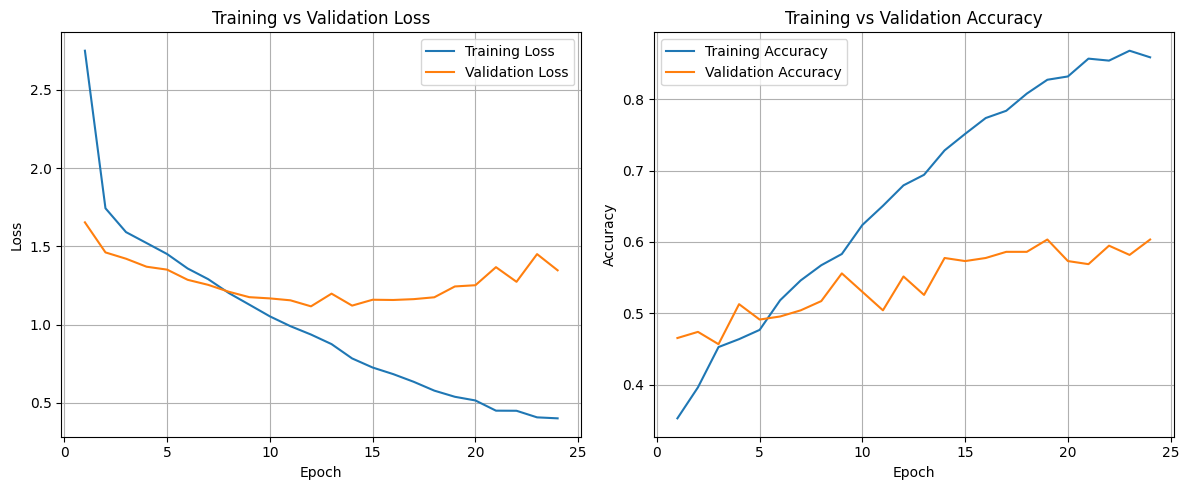

In [25]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

# ===== Loss Curve =====
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# ===== Accuracy Curve =====
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label="Training Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
